In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, Model
from keras import applications
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from scipy import spatial
import pathlib
from sklearn.model_selection import train_test_split
import pickle

## Sélection des données

In [12]:
data_dir = pathlib.Path("DATA") # indiquer chemin  où sont les données

In [13]:
image_count = len(list(data_dir.glob('*/*'))) # compte le nb d'images dans le dossier
image_count

1051

In [14]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]) 
CLASS_NAMES # liste des noms de dossiers (qui sont nos classes)

array(['D46D', 'De', 'F35', 'G17', 'G43', 'I10', 'M17 ou T35', 'oeil',
       'Pour,vers', 'S21', 'S34', 'Triangle', 'V30'], dtype='<U10')

paramétrage du télechargement des images

In [15]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # redimension des images
BATCH_SIZE = image_count
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

Téléchargement des images sélectionnées

In [16]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))
#On importe les images

Found 1061 images belonging to 13 classes.


In [17]:
with open(r"Sauvegarde modèle\path.txt", "wb") as fp:  #sauvegarde de l'emplacement des fichiers
     pickle.dump(train_data_gen.filenames, fp)

Affichage des premières images originales 

In [18]:
def show_batch(image_batch, label_batch):
    """
    Montre les 25 premières images d'un dataset
    Entrée : Liste d'images et de labels sous forme de listes numpy
    Sortie : Affichage des 25 premières envoyé en entrée 
    """
    plt.figure(figsize=(10,10))
    for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
#Fonction d'affichage des images

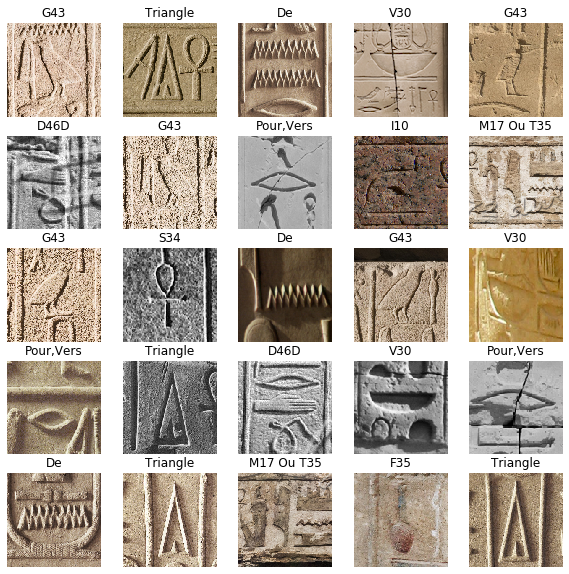

In [19]:
image_batch, label_batch = next(train_data_gen) #Pour séparer le label de l'image
show_batch(image_batch, label_batch)

## Data augmentation

In [20]:
def augm(datagen):
    """
    Fonction qui renvoie une liste d'images modifier.
    Entrée : Mofication de type keras.preprocessing.image.ImageDataGenerator.
    Sortie : Images modifier sous forme de liste numpy.
    """
    datagen.fit(image_batch)
    augmT = []
    for el in datagen.flow(image_batch,shuffle=False,batch_size=BATCH_SIZE):
        for i in range(0, len(el)):
            if i == 0 : augmT.append(el[i])
            else : augmT.append(el[i])

        break
    augmT =  np.array(augmT)
    return augmT
        

sélection des méthodes d'augmentation de données

In [21]:
datagen = []
datagen.append(ImageDataGenerator(rotation_range=30))
datagen.append(ImageDataGenerator(zoom_range=[0.5,1.0]))
datagen.append(ImageDataGenerator(brightness_range=[0.9,1.01]))
datagen.append(ImageDataGenerator(fill_mode='constant'))
datagen.append(ImageDataGenerator(cval=255))
datagen.append(ImageDataGenerator(width_shift_range=[-50,50]))

Concaténation des nouvelles images modifiées et images originales

In [22]:
for i,gen in enumerate(datagen) :
    if i == 0:
        new_img =  np.concatenate((image_batch,augm(gen)))
        new_label =  np.concatenate((label_batch,label_batch))
    else: 
        new_img =  np.concatenate((new_img,augm(gen)))
        new_label =  np.concatenate((new_label,label_batch))


In [23]:
print(np.shape(image_batch)) # dimension images avant data augmentation
print(np.shape(label_batch)) # dimension label avant data augmentation

(1051, 224, 224, 3)
(1051, 13)


In [24]:
print(np.shape(new_img)) # dimension images après data augmentation
print(np.shape(new_label))  # dimension label après data augmentation

(7357, 224, 224, 3)
(7357, 13)


## Modèle
Split train/test

In [25]:
(trainX, testX, trainY, testY) = train_test_split(new_img, new_label, test_size=0.25)

In [26]:
# configuration sauvegarde weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="weights/checkpoint_tfl.h5",
                                                 save_weights_only=True,
                                                 verbose=1)

Création du modèle, en utilisant le transfer learning ( VGG19 est le modèle choisit)

In [27]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3)) # transfer learning
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(CLASS_NAMES), activation="softmax")(x)

Paramètrage du modèle et fit sur les données d'entrainement et de test.

In [28]:
model_final = Model(input = model.input, output = predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
history = model_final.fit(trainX, trainY, epochs=10, 
                    validation_data=(testX, testY))
#,callbacks=[cp_callback]

C:\Users\theoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


Train on 5517 samples, validate on 1840 samples
Epoch 1/10
 288/5517 [>.............................] - ETA: 1:00:54 - loss: 3.8593 - accuracy: 0.1111

KeyboardInterrupt: 

Affichage de l'accuracy du modèle par epoch ( accuracy  = train et val_accuracy = test )

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_final.evaluate(testX,  testY, verbose=2)

Accuracy total du modèle

In [ ]:
print(test_acc)

Sauvegarde du modèle pour la prod

In [ ]:
model_final.save("Sauvegarde modèle/model_sauvegarde")

##  Extraction de la représentation

Création d'un modèle reprenant le modèle précedent supprimant le dernier layer de probabilité

In [ ]:
model_simi = Model(input = model.input, output =x)

Réalisation de la prédiction de toutes les images pour en avoir la représentation du modèle.
Sélection de l'image dont on veut les images similaires, ainsi que du nombre d'images similaires.

In [ ]:
pred = model_simi.predict(image_batch) # prédiction sur toutes les images non modifié 
quer = pred[4] # selection de l'image auquelle il faut trouver les images similaire
nb = 6 # nombre d'image similaire

Sauvegarde représentation pour prod

In [ ]:
model_simi.save("Sauvegarde modèle/simi_sauvegarde")
np.save('Sauvegarde modèle/representation.npy',  pred)
np.save('Sauvegarde modèle/img.npy', image_batch )
np.save('Sauvegarde modèle/label.npy', label_batch )
np.save('Sauvegarde modèle/class.npy', CLASS_NAMES )

In [ ]:
"""from sklearn.manifold import TSNE
X = TSNE(n_components=3).fit_transform(test) # réduction de dimension """

Recherche des images similaires ( recherche des points les plus proches)

In [ ]:
distance,index = spatial.KDTree(pred).query(quer,k=nb+1)                                             

Image choisis

In [ ]:
plt.imshow(np.squeeze(image_batch[index[0]]))

Images similaires

In [ ]:
distance = distance[1:]
index = index[1:]
plt.figure(figsize=(10,10))
for n in range(len(index)):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(np.squeeze(image_batch[index[n]]))
      plt.title(CLASS_NAMES[label_batch[index[n]]==1][0].title())
      plt.axis('off')